Libraries used

In [ ]:
from google.colab import drive
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import EllipseModel
from scipy.optimize import least_squares

Drive acess to use Data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


csv understanding

*   0--> Shape
*   1--> Direction
*   2-->x axis
*   2-->y axis

In [ ]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs
a=read_csv('/content/drive/MyDrive/adobe/gensolve/problems/isolated.csv')


print(len(a)) ## all 3 shapes
print(len(a[0])) ##circle
print(len(a[0][0])) ## repesesnting circle
print(len(a[0][0][0])) ## representing x,y coords

3
1
419
2


Plotting Whole Diagram


The rdp function implements the Ramer-Douglas-Peucker (RDP) algorithm, which is a method for simplifying a curve composed of a series of points while retaining its overall shape. Here’s what the code does:

This function computes the perpendicular distance of a point from a line segment defined by line_start and line_end. It uses the cross product to find the distance from the point to the line segment, normalized by the length of the segment.

In [ ]:
def rdp(points, epsilon):
    def perpendicular_distance(point, line_start, line_end):
        if np.all(line_start == line_end):
            return np.linalg.norm(point - line_start)
        return np.abs(np.cross(line_end - line_start, point - line_start)) / np.linalg.norm(line_end - line_start)

    def rdp_recursive(points, epsilon):
        if len(points) < 2:
            return points

        start, end = points[0], points[-1]
        distances = np.array([perpendicular_distance(point, start, end) for point in points[1:-1]])
        index = np.argmax(distances) + 1

        if distances[index - 1] > epsilon:
            return np.vstack((rdp_recursive(points[:index + 1], epsilon), rdp_recursive(points[index:], epsilon)[1:]))
        else:
            return np.array([start, end])

    return rdp_recursive(points, epsilon)




applying the RDP algorithm to each segment of every path. It processes each segment independently and then returns the list of paths with their segments simplified according to the given epsilon value.

In [ ]:
def apply_rdp(path_XYs, epsilon=1.0):
    simplified_paths = []
    for path in path_XYs:
        simplified_path = [rdp(segment, epsilon=epsilon) for segment in path]
        simplified_paths.append(simplified_path)
    return simplified_paths


reflection in vertical

In [ ]:
def reflect_points_across_vertical(points, x_line):
    return np.array([[2 * x_line - x, y] for x, y in points])

reflection in Horizontal

In [ ]:
def reflect_points_across_horizontal(points, y_line):
    return np.array([[x, 2 * y_line - y] for x, y in points])

Reflection along any line


In [ ]:
def reflect_points_across_line(points, line_point, line_direction):
    line_point = np.array(line_point)
    line_direction = np.array(line_direction) / np.linalg.norm(line_direction)
    reflected_points = []
    for point in points:
        point = np.array(point)
        projection_length = np.dot(point - line_point, line_direction)
        projection = line_point + projection_length * line_direction
        reflection = 2 * projection - point
        reflected_points.append(reflection)
    return np.array(reflected_points)

reflects a collection of paths across vertical, horizontal, or diagonal lines based on the specified symmetry_type. It calculates the appropriate line of symmetry for each segment of each path, applies the reflection, and returns the list of all reflected paths.

In [ ]:
def find_symmetry_and_reflect_1(path_XYs, symmetry_type):
    reflected_paths = []
    for path in path_XYs:
        reflected_path = []
        for segment in path:
            if symmetry_type == "vertical":
                x_line = (segment[:, 0].min() + segment[:, 0].max()) / 2
                reflected_segment = reflect_points_across_vertical(segment, x_line)
            elif symmetry_type == "horizontal":
                y_line = (segment[:, 1].min() + segment[:, 1].max()) / 2
                reflected_segment = reflect_points_across_horizontal(segment, y_line)
            elif symmetry_type == "diagonal":
                line_point = [(segment[:, 0].min() + segment[:, 0].max()) / 2,
                              (segment[:, 1].min() + segment[:, 1].max()) / 2]
                line_direction = [1, 1]
                reflected_segment = reflect_points_across_line(segment, line_point, line_direction)
            reflected_path.append(reflected_segment)
        reflected_paths.append(reflected_path)
    return reflected_paths


every 10 degree check

In [ ]:
def find_symmetry_and_reflect(path_XYs, symmetry_type):
    if symmetry_type == "angles":
        angles = np.arange(0, 181, 10)
        reflected_paths_by_angle = {}

        for angle in angles:
            line_direction = [np.cos(np.radians(angle)), np.sin(np.radians(angle))]
            reflected_paths = []

            for path in path_XYs:
                reflected_path = []
                for segment in path:
                    line_point = [(segment[:, 0].min() + segment[:, 0].max()) / 2,
                                  (segment[:, 1].min() + segment[:, 1].max()) / 2]
                    reflected_segment = reflect_points_across_line(segment, line_point, line_direction)
                    reflected_path.append(reflected_segment)
                reflected_paths.append(reflected_path)

            reflected_paths_by_angle[angle] = reflected_paths

        return reflected_paths_by_angle

plots orignal and reflected path

In [ ]:
def plot_paths_with_symmetry(original_paths, reflected_paths, colours, symmetry_type):
    fig, ax = plt.subplots(figsize=(8, 8))
    color_idx = 0
    for original_path, reflected_path in zip(original_paths, reflected_paths):
        for segment, reflected_segment in zip(original_path, reflected_path):
            if len(segment) > 0:
                segment = np.array(segment)
                ax.plot(segment[:, 0], segment[:, 1], c=colours[color_idx % len(colours)], linewidth=2)
                ax.plot(reflected_segment[:, 0], reflected_segment[:, 1], c=colours[(color_idx + 1) % len(colours)], linestyle='--', linewidth=2)
        color_idx += 1
    ax.set_aspect('equal')
    plt.grid(True, which='both', color='lightgray', linestyle='--')
    plt.title(f"Original and {symmetry_type.capitalize()} Reflected Paths")
    plt.show()

Plotting whole drawing


In [ ]:

def plot(path_XYs, colours):
    fig, ax = plt.subplots(figsize=(8, 8))
    color_idx = 0
    for path in path_XYs:
        for segment in path:
            if len(segment) > 0:
                segment = np.array(segment)
                ax.plot(segment[:, 0], segment[:, 1], c=colours[color_idx % len(colours)], linewidth=2)
        color_idx += 1
    ax.set_aspect('equal')

    plt.grid(True, which='both', color='lightgray', linestyle='--')
    plt.show()


running funcion on a Drawing


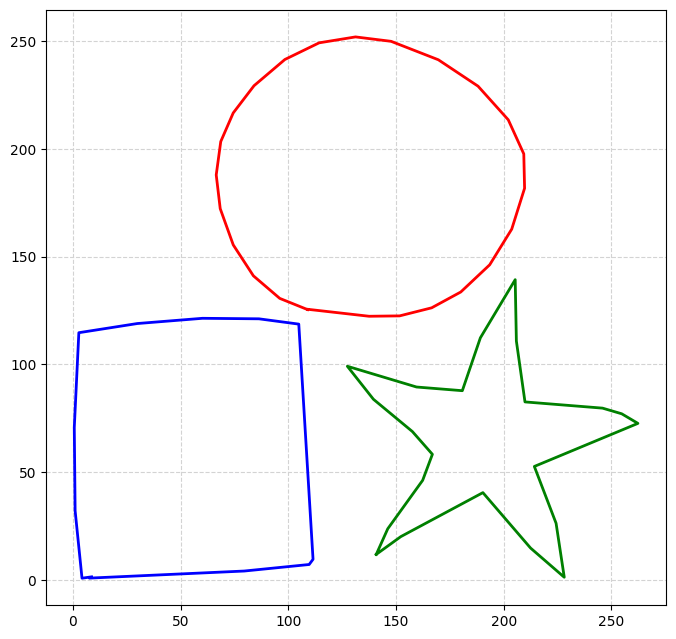

In [ ]:


csv_path = "/content/drive/MyDrive/adobe/gensolve/problems/isolated.csv"
path_XYs = read_csv(csv_path)
simplified_paths = apply_rdp(path_XYs, epsilon=1.0)

colours = ['r', 'g', 'b']

plot(simplified_paths, colours)

Visualizing all symmetries

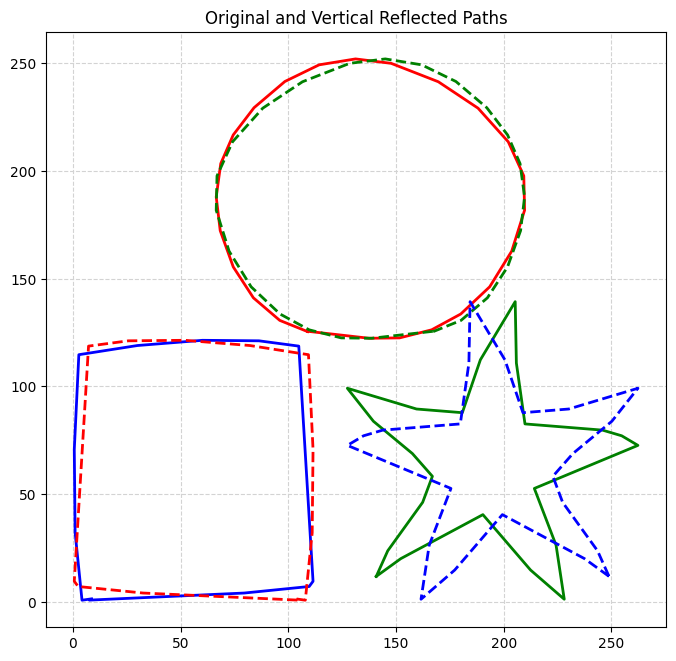

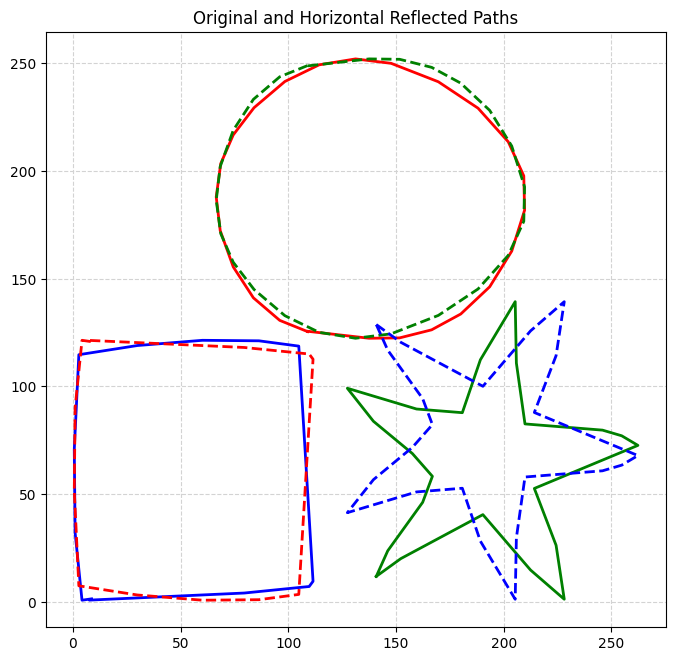

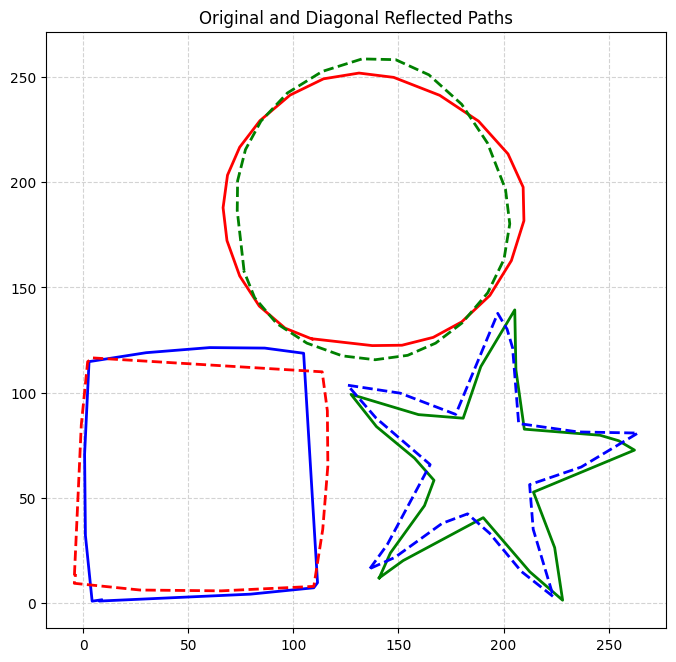

In [ ]:

reflected_paths_vertical = find_symmetry_and_reflect_1(simplified_paths, "vertical")
plot_paths_with_symmetry(simplified_paths, reflected_paths_vertical, colours, "vertical")

reflected_paths_horizontal = find_symmetry_and_reflect_1(simplified_paths, "horizontal")
plot_paths_with_symmetry(simplified_paths, reflected_paths_horizontal, colours, "horizontal")

reflected_paths_diagonal = find_symmetry_and_reflect_1(simplified_paths, "diagonal")
plot_paths_with_symmetry(simplified_paths, reflected_paths_diagonal, colours, "diagonal")

Evaluating how good is a symmetry line

In [ ]:
def calculate_alignment(original_paths, reflected_paths):
    total_distance = 0
    count = 0
    for original_path, reflected_path in zip(original_paths, reflected_paths):
        for original_segment, reflected_segment in zip(original_path, reflected_path):
            if len(original_segment) > 0 and len(reflected_segment) > 0:

                min_len = min(len(original_segment), len(reflected_segment))
                original_segment = original_segment[:min_len]
                reflected_segment = reflected_segment[:min_len]

                distances = np.linalg.norm(original_segment - reflected_segment, axis=1)
                total_distance += np.sum(distances)
                count += len(distances)
    return total_distance / count if count > 0 else float('inf')

finding best symmetry axis

In [ ]:
def find_best_symmetry_axis(original_paths):
    reflected_paths_by_angle = find_symmetry_and_reflect(original_paths, "angles")
    best_angle = None
    best_score = float('inf')

    for angle, reflected_paths in reflected_paths_by_angle.items():
        alignment_score = calculate_alignment(original_paths, reflected_paths)
        print(f"Alignment score for {angle} degrees symmetry: {alignment_score:.2f}")

        if alignment_score < best_score:
            best_score = alignment_score
            best_angle = angle

    return best_angle,best_score

plotting the symmetries

In [ ]:
def plot_best_symmetry(original_paths, best_angle):
    reflected_paths_by_angle = find_symmetry_and_reflect(original_paths, "angles")
    reflected_paths = reflected_paths_by_angle[best_angle]
    plot_paths_with_symmetry(original_paths, reflected_paths, colours, f"{best_angle} degrees")


scoring symmetries



Alignment score for 0 degrees symmetry: 80.42
Alignment score for 10 degrees symmetry: 79.57
Alignment score for 20 degrees symmetry: 78.90
Alignment score for 30 degrees symmetry: 77.31
Alignment score for 40 degrees symmetry: 74.92
Alignment score for 50 degrees symmetry: 73.39
Alignment score for 60 degrees symmetry: 75.70
Alignment score for 70 degrees symmetry: 78.27
Alignment score for 80 degrees symmetry: 79.71
Alignment score for 90 degrees symmetry: 80.88
Alignment score for 100 degrees symmetry: 81.37
Alignment score for 110 degrees symmetry: 80.99
Alignment score for 120 degrees symmetry: 81.18
Alignment score for 130 degrees symmetry: 81.21
Alignment score for 140 degrees symmetry: 81.53
Alignment score for 150 degrees symmetry: 82.19
Alignment score for 160 degrees symmetry: 81.87
Alignment score for 170 degrees symmetry: 81.39
Alignment score for 180 degrees symmetry: 80.42
Best symmetry angle found: 50 degrees


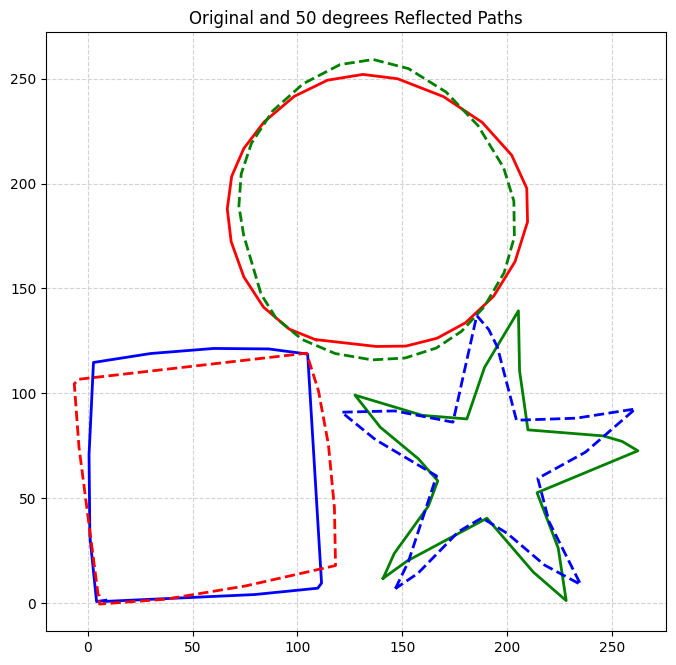

In [ ]:
best_angle, best_score= find_best_symmetry_axis(simplified_paths)

if best_score <90:
    print(f"Best symmetry angle found: {best_angle} degrees")
    plot_best_symmetry(simplified_paths, best_angle)
else:
    print("No suitable symmetry angle found.")


Testing on Other Examples

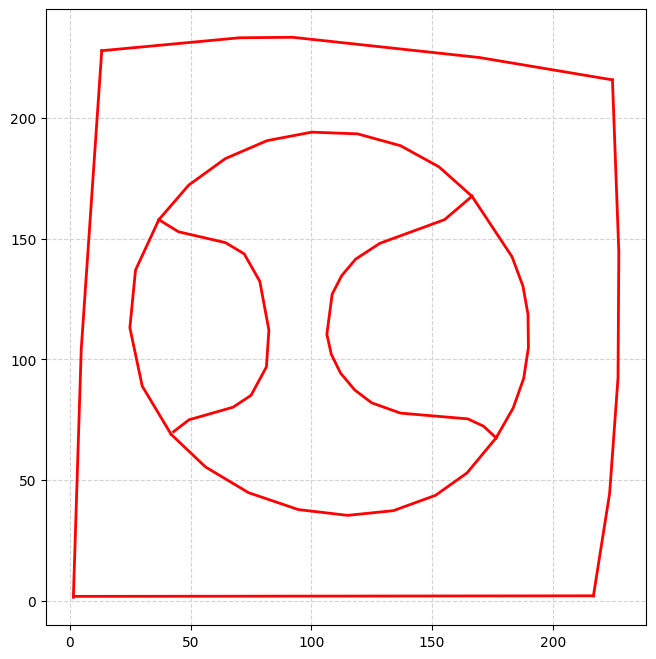

In [ ]:


csv_path = "/content/drive/MyDrive/adobe/gensolve/problems/frag0.csv"
path_XYs = read_csv(csv_path)
simplified_paths = apply_rdp(path_XYs, epsilon=1.0)

colours = ['r']

plot(simplified_paths, colours)

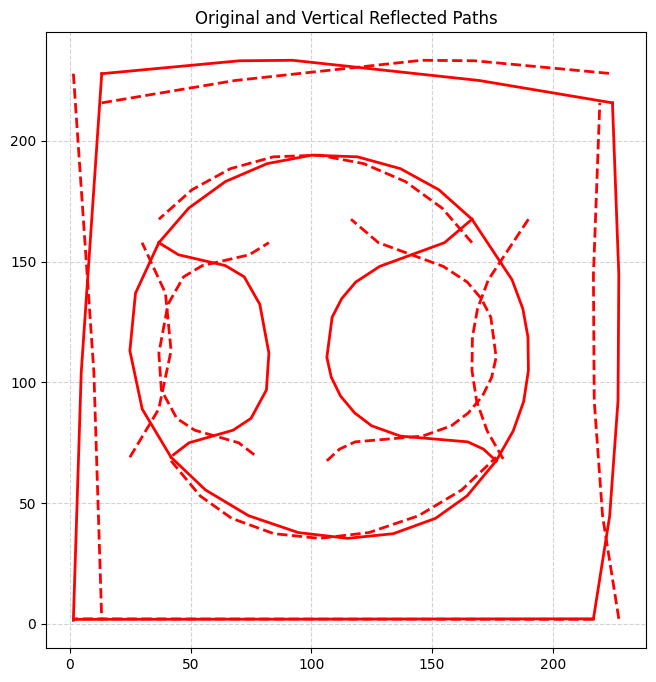

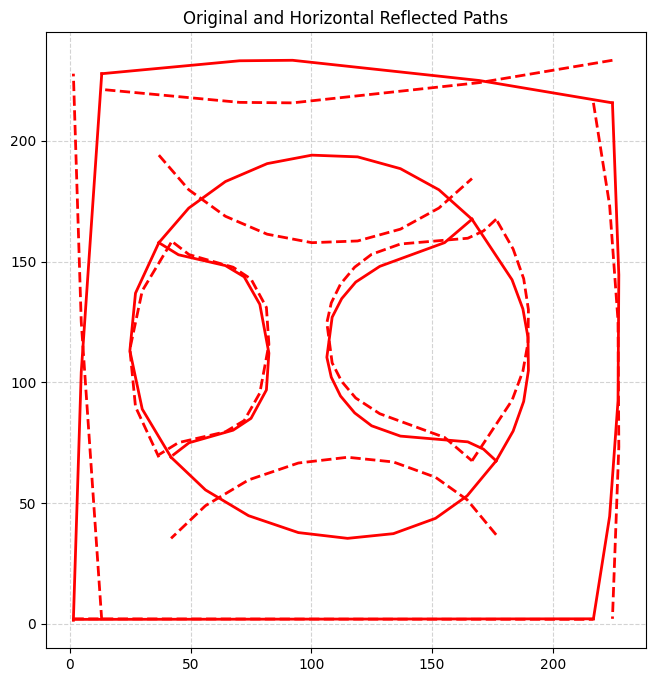

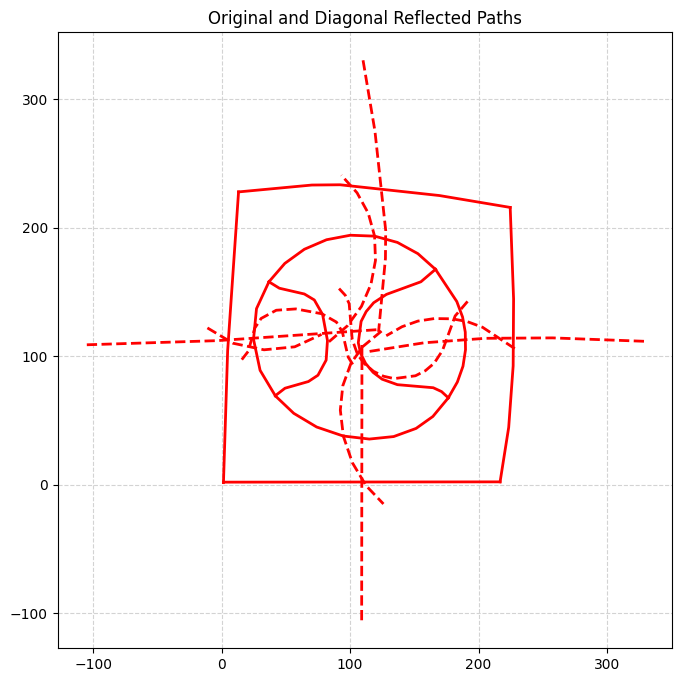

In [ ]:

reflected_paths_vertical = find_symmetry_and_reflect_1(simplified_paths, "vertical")
plot_paths_with_symmetry(simplified_paths, reflected_paths_vertical, colours, "vertical")

reflected_paths_horizontal = find_symmetry_and_reflect_1(simplified_paths, "horizontal")
plot_paths_with_symmetry(simplified_paths, reflected_paths_horizontal, colours, "horizontal")

reflected_paths_diagonal = find_symmetry_and_reflect_1(simplified_paths, "diagonal")
plot_paths_with_symmetry(simplified_paths, reflected_paths_diagonal, colours, "diagonal")

Alignment score for 0 degrees symmetry: 53.90
Alignment score for 10 degrees symmetry: 56.70
Alignment score for 20 degrees symmetry: 59.71
Alignment score for 30 degrees symmetry: 62.12
Alignment score for 40 degrees symmetry: 62.87
Alignment score for 50 degrees symmetry: 62.39
Alignment score for 60 degrees symmetry: 60.72
Alignment score for 70 degrees symmetry: 58.00
Alignment score for 80 degrees symmetry: 55.16
Alignment score for 90 degrees symmetry: 53.56
Alignment score for 100 degrees symmetry: 55.14
Alignment score for 110 degrees symmetry: 56.66
Alignment score for 120 degrees symmetry: 58.21
Alignment score for 130 degrees symmetry: 59.81
Alignment score for 140 degrees symmetry: 60.39
Alignment score for 150 degrees symmetry: 59.72
Alignment score for 160 degrees symmetry: 57.93
Alignment score for 170 degrees symmetry: 55.17
Alignment score for 180 degrees symmetry: 53.90
Best symmetry axis found: 90


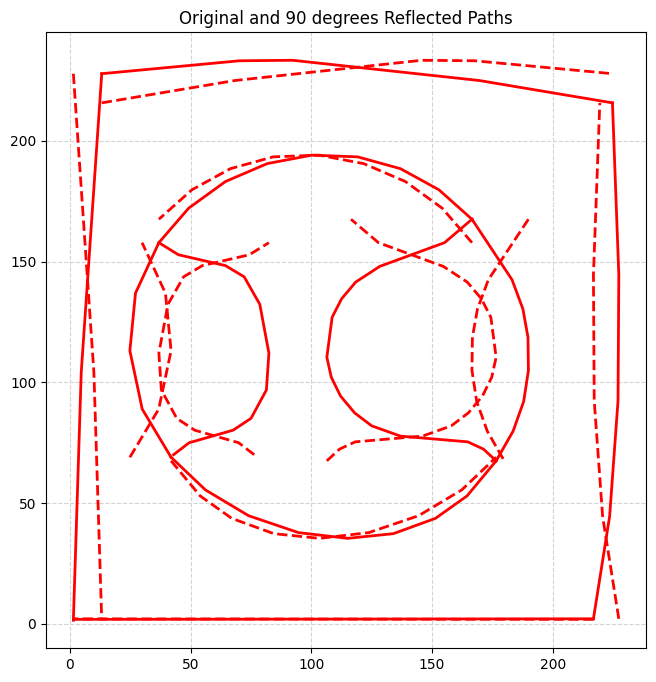

In [ ]:
best_axis,best_score = find_best_symmetry_axis(simplified_paths)

if best_score<95:
    print(f"Best symmetry axis found: {best_axis}")
    plot_best_symmetry(simplified_paths, best_axis)
else:
    print("No suitable symmetry axis found.")